In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import time
import matplotlib.pyplot as plt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
vars= ['fireClass','v10wind','u10wind','sm_surface','sTemp','Wind','elevation','nlcd','evi','vwc']
file= "/home/cx43/cee690-07/data/2018fire/test2_fire_Nov29.csv"
dataset= pd.read_csv(file)
df = pd.DataFrame(dataset)

predictors= ['v10wind','u10wind','sm_surface','sTemp','Wind','elevation','nlcd','evi','vwc']

new_predictors= predictors.copy()
for i,var1 in enumerate(predictors):
    for j,var2 in enumerate(predictors[i::]):
        name= '{0}*{1}'.format(var1,var2)
        df[name]= df[var1]*df[var2]
        new_predictors.append(name)

In [3]:
time_model = pm.Model()
with time_model:
    intercept = pm.Normal('intercept',mu=0,sd=100)
    beta   = pm.Normal('beta',shape=len(new_predictors),sd=100)  
    variance  = pm.InverseGamma('variance',alpha=0.1,beta=0.1)
    sd        = pm.Deterministic('sd',variance**0.5)
    
    yhat = pm.Deterministic('yhat',intercept + pm.math.dot(df[new_predictors], beta))
   
    tau      = pm.Gamma('tau',0.1,0.1)
    k        = pm.Uniform('k')
    error    = pm.AR1('error', k=k, tau_e=tau, observed=(yhat-df['fireClass']).T)   
    trace = pm.sample(tune=3000,nuts_kwargs=dict(target_accept=0.95))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, tau, variance, beta, intercept]
Sampling 4 chains: 100%|██████████| 14000/14000 [1:03:28<00:00,  3.68draws/s]


In [4]:
with time_model: 
    print(pm.stats.r2_score(df['fireClass'].values,trace[yhat]))

r2_r(r2_median=0.73, r2_mean=0.73, r2_std=0.0)


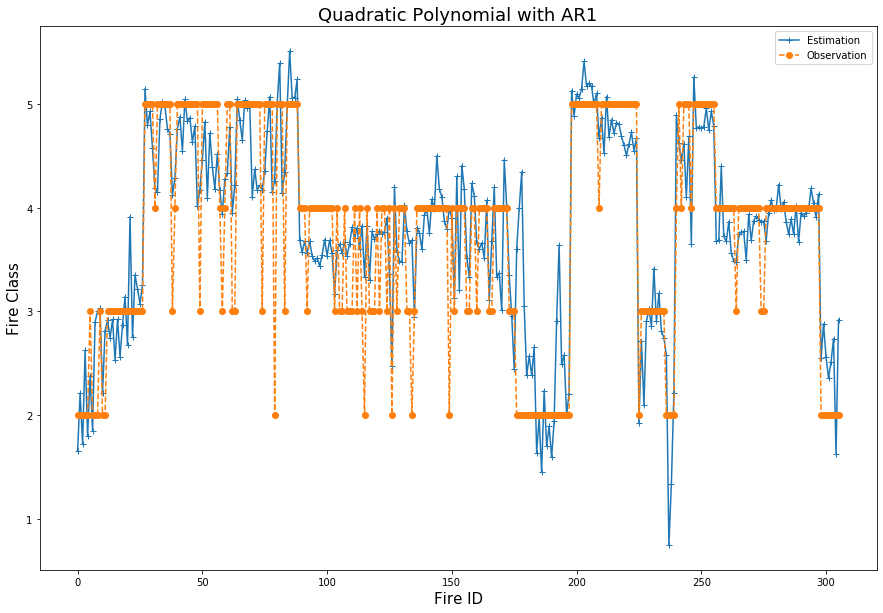

In [52]:
%matplotlib inline

y_pred= trace['yhat'][1]
y_true= df['fireClass']

plt.figure(figsize=(15,10))
x= np.linspace(0,305,306)
plt.plot(x,y_pred,marker='+')
plt.plot(x,y_true,marker='o', linestyle='dashed')
plt.xlabel('Fire ID',fontsize=15)
plt.ylabel('Fire Class',fontsize=15)
plt.legend(['Estimation', 'Observation'])
plt.title('Quadratic Polynomial with AR1',fontsize=18)
plt.show()

(<Figure size 576x11232 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f20ec272390>,
       dtype=object))

<Figure size 216x4320 with 0 Axes>

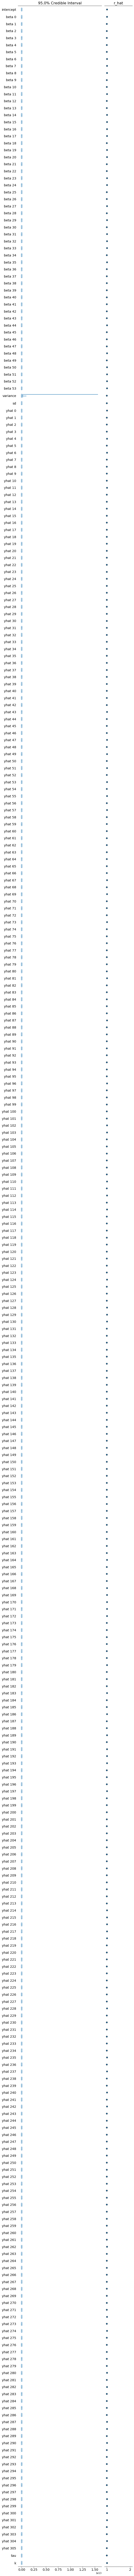

In [8]:
plt.figure(figsize=(3,60))
pm.forestplot(trace,credible_interval= 0.95,r_hat=True)

/home/cx43/cee690-07/stats/lib/python3.7/site-packages/arviz/plots/plot_utils.py:506: SyntaxWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (365) in plot_posterior, generating only 40 plots
  SyntaxWarning,


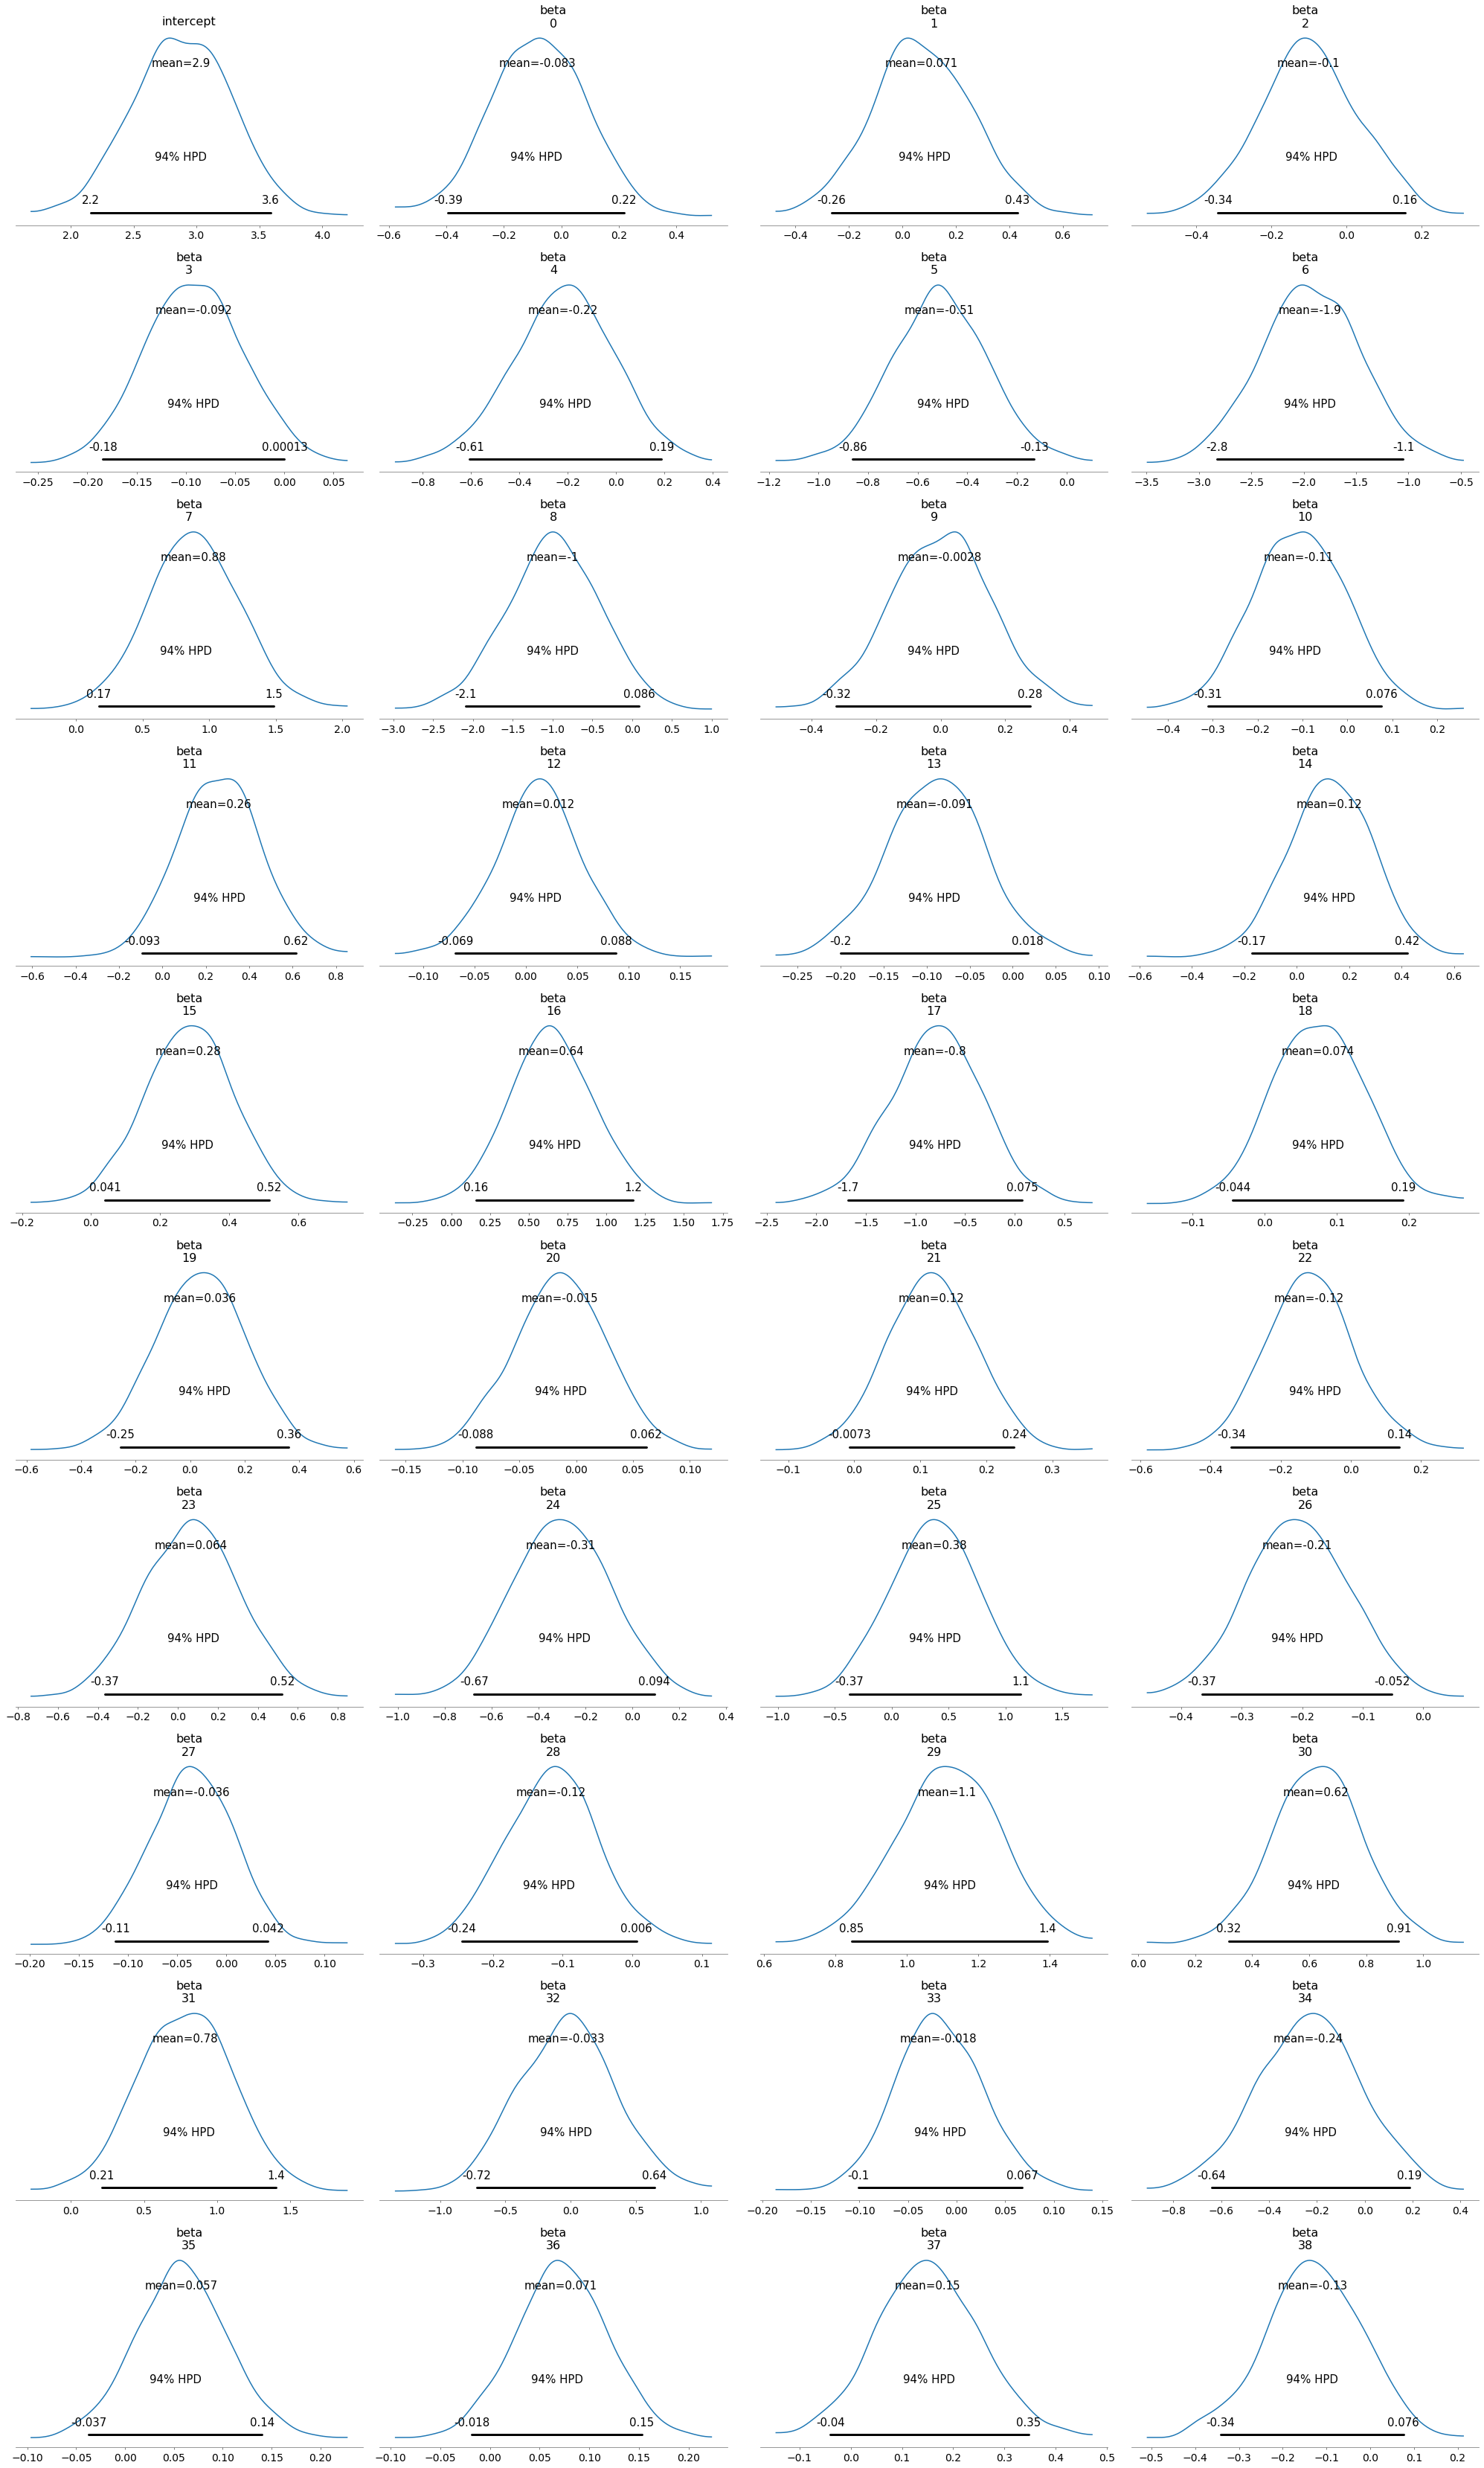

In [9]:
pm.plot_posterior(trace);

In [10]:
pm.summary(trace)

/home/cx43/cee690-07/stats/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
intercept,2.876660,0.389862,0.012655,2.133954,3.632827,780.218942,1.003439
beta__0,-0.083071,0.165853,0.005352,-0.409690,0.233013,835.933059,1.003610
beta__1,0.070510,0.185187,0.005750,-0.294981,0.430317,912.417799,1.000758
beta__2,-0.101095,0.133808,0.003402,-0.345004,0.173718,1354.216948,0.999362
beta__3,-0.092197,0.049396,0.001152,-0.187849,0.002587,1462.867120,0.999685
...,...,...,...,...,...,...,...
yhat__303,2.561249,0.375673,0.006960,1.862515,3.331628,2787.205222,1.000107
yhat__304,1.720913,0.370775,0.007993,0.966759,2.434682,1932.242898,1.002449
yhat__305,2.655096,0.289142,0.006114,2.061164,3.184609,2224.476691,0.999443
tau,3.418810,0.316166,0.007038,2.886358,4.106370,1788.821601,0.999828


In [12]:
pm.stats.waic(trace,model= time_model)

/home/cx43/cee690-07/stats/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.
/home/cx43/cee690-07/stats/lib/python3.7/site-packages/pymc3/stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=540.8535132889112, WAIC_se=0.0, p_WAIC=33.751113329866065, var_warn=1)

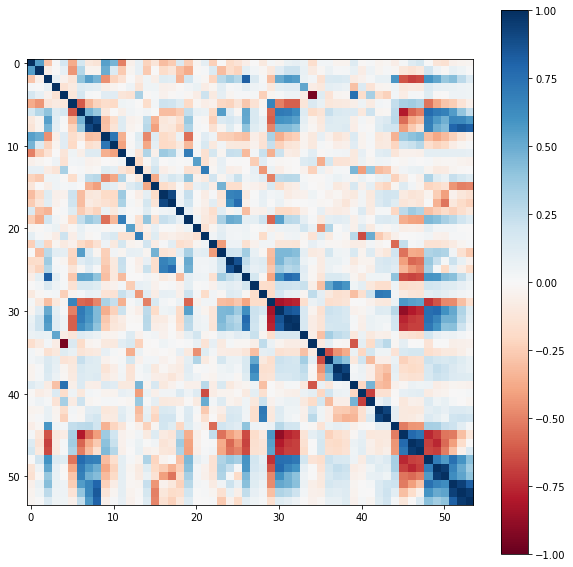

In [16]:
plt.figure(figsize=(10,10))
correlations = df[new_predictors].corr()
plt.imshow(correlations,vmin=-1,vmax=1,cmap='RdBu')
plt.colorbar()
plt.show()

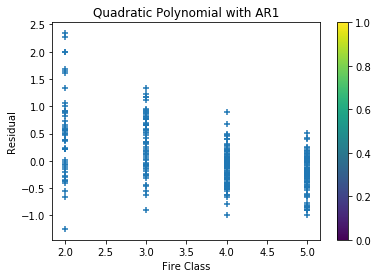

5% percentile -0.6649614426535805
95% percentile 0.9478980646227901


In [34]:
delta= y_pred -y_true
x= np.linspace(0,305,306)

plt.scatter(y_true,delta,marker='+')
plt.xlabel('Fire Class')
plt.ylabel('Residual')
plt.colorbar()
plt.title('Quadratic Polynomial with AR1')
plt.show()

print('5% percentile', np.percentile(delta,5))
print('95% percentile',np.percentile(delta,95))

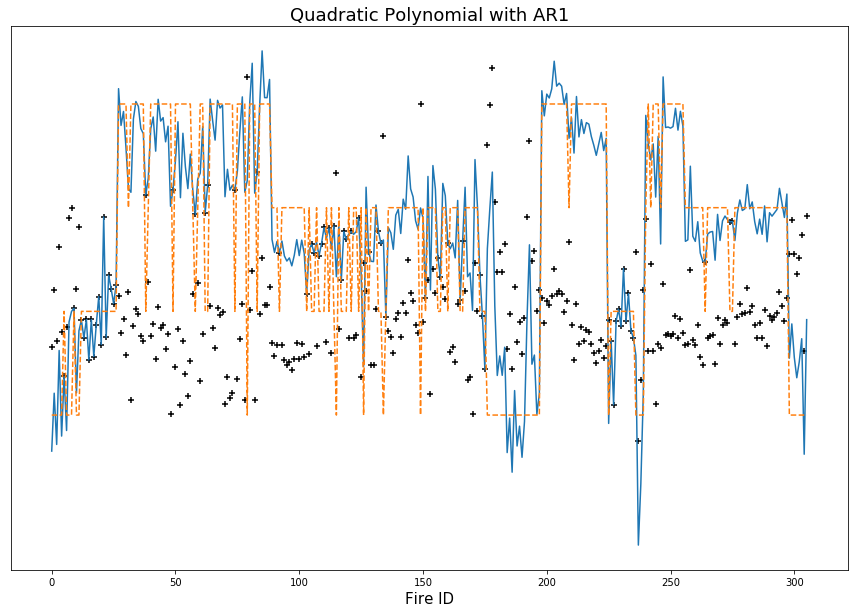

In [49]:
plt.figure(figsize=(15,10))
x= np.linspace(0,305,306)
plt.plot(x,y_pred)
plt.plot(x,y_true,linestyle='dashed')
plt.scatter(x,delta+3,marker='+',color='k')
plt.xlabel('Fire ID',fontsize=15)
plt.yticks([])
plt.title('Quadratic Polynomial with AR1',fontsize=18)
plt.show()